In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

# README
This demo shows how to evaluate your predictions (read from a file) with the IPD toolkit

## 0. Install IPD package & Import
Note: Also installs notebook packages for running demos. Omit the optional `notebooks` group if you don't want this.
### Option 1 (from source):
1. Clone this github repo
2. Run `pip install -e .[notebooks]` 
    1. Make sure you are using a compatible python version (tested with 3.9.2 and 3.10.14)
    2. Recommend using a venv

### Option 2 (not available yet):
1. `pip install intrinsic-ipd[notebooks]`

### Option 3:
1. `pip install git+[github/http/url]@main[notebooks]`

In [2]:
from intrinsic_ipd import IPDReader, IPDCamera, IPDImage, IPDLightCondition, CameraFramework
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pprint import pprint
np.set_printoptions(suppress=True, precision=4)
import itertools

In [3]:
import logging
logging.basicConfig(
    level=logging.INFO,  # Set the logging level (INFO, DEBUG, WARNING, etc.)
    format="%(asctime)s - %(name)s - %(levelname)s - %(filename)s - %(funcName)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

# 1. Read Dataset

In [4]:
reader = IPDReader("./datasets", "dataset_darkbg_0", IPDCamera.PHOTONEO, lighting=IPDLightCondition.ROOM, download=True) 
reader.objects

2024-09-21 00:21:07 - root - INFO - reader.py - __init__ - 
	Dataset:	dataset_darkbg_0
	Dataset Path:	./datasets/dataset_darkbg_0/test
	Camera Type:	Photoneo (ID: 000)
	Lighting:	ROOM
	Num Scenes:	30


[('gear2', 0),
 ('gear2', 1),
 ('gear2', 2),
 ('gear2', 3),
 ('gear2', 4),
 ('hex_manifold', 0),
 ('hex_manifold', 1)]

# 2. Read and Match Predictions to Ground Truth

### 1. Instantiate the matcher
If the predicted poses of multiple instances of a part are to be provided in order, use the `ordered=True` setting. Otherwise, matching of predictions to ground truth instances is done based on translation distance.

In [5]:
from intrinsic_ipd.matcher import PoseMatcher

ordered_matcher = PoseMatcher(reader, ordered=True) #NOTE: this matches predictions based on list order

# matcher = PoseMatcher(reader, match_dist_default_thresh = 10) #NOTE: this matches predictions to instances based on tranlation distance

2024-09-21 00:21:07 - root - INFO - matcher.py - __init__ - Distance thresholds by part:{'corner_bracket': 32.38017666683971, 'corner_bracket0': 39.02804491183019, 'corner_bracket1': 10.877681825412408, 'corner_bracket2': 500, 'corner_bracket3': 26.39645391091472, 'corner_bracket4': 24.395902842373566, 'corner_bracket5': 18.918008035086167, 'corner_bracket6': 17.808145893935368, 'gear1': 25.815695401421685, 'gear2': 29.26397887556897, 'handrail_bracket': 500, 'hex_manifold': 500, 'l_bracket': 64.66071511009928, 'oblong_float': 62.70328076467595, 'pegboard_basket': 126.52277583794437, 'pipe_fitting_unthreaded': 40.67292674500291, 'single_pinch_clamp': 42.761346229284214, 'square_bracket': 43.12704523580799, 't_bracket': 53.88417685702441, 'u_bolt': 71.575479466246, 'wraparound_bracket': 49.71277681037156}


### 2. Register the estimated poses. 

In the following case, pose estimates are read from a file and registered with the matcher by scene and part. By default `mode="override"`, which will erase any previously registered poses for that scene and part and only save the provided poses. If you would like to append poses rather than override, use `mode="append"`.

In [6]:
import yaml
import numpy as np

file = "./demo_results/dataset_darkbg_0_PHOTONEO.yml"
with open(file) as stream:
    poses_by_part_by_scene = yaml.safe_load(stream)
poses_by_object_by_scene = {}
for scene in poses_by_part_by_scene:
    poses_by_part = poses_by_part_by_scene[scene]
    poses_by_object_by_scene[scene] = {}
    for part in poses_by_part:
        poses = poses_by_part[part] #dict
        poses = [poses[key] for key in sorted(poses.keys(), reverse=False)] #NOTE: sorted values by instance
        poses = np.array(poses)
        poses[:,:3, 3] *= 1e3
        ordered_matcher.register_poses(scene, part, poses, mode="override")
        # matcher.register_poses(scene, part, poses, mode="override")
        

In [7]:
matched_poses_xarr = ordered_matcher.get_matched_poses()

# 3. Evaluate

### 1. Instantiate the Evaluator

In [8]:
from intrinsic_ipd.evaluator import Evaluator
evaluator = Evaluator(reader)

### 2. Evaluate using annotated ground truth

In [9]:
evaluator.measure_ground_truth_accuracy(matched_poses_xarr).to_pandas()

part          instance
gear2         0            4.713135
              1            4.269179
              2            4.309647
              3            4.547010
              4            4.489904
hex_manifold  0            8.417651
              1           70.674926
dtype: float64

### 3. Evaluate using robot consistency

In [10]:
evaluator.measure_robot_consistency(ordered_matcher.get_matched_poses()).to_pandas()

part          instance
gear2         0            1.118934
              1            1.305575
              2            1.456735
              3            1.512205
              4            1.350184
hex_manifold  0            4.354976
              1           84.739032
dtype: float64

### 4. Getting prediction stats after matching

In [11]:
ordered_matcher.get_stats()

<xarray.DataArray (counts: 3, part: 2)>
array([[150,  60],
       [150,  60],
       [150,  60]])
Coordinates:
  * part     (part) object 'gear2' 'hex_manifold'
  * counts   (counts) object 'true_positive' 'test_positive' 'actual_positive'
    dataset  <U16 'dataset_darkbg_0'

In [12]:
evaluator.recall(ordered_matcher)

<xarray.DataArray (part: 2)>
array([1., 1.])
Coordinates:
  * part     (part) object 'gear2' 'hex_manifold'
    dataset  <U16 'dataset_darkbg_0'

In [13]:
evaluator.precision(ordered_matcher)

<xarray.DataArray (part: 2)>
array([1., 1.])
Coordinates:
  * part     (part) object 'gear2' 'hex_manifold'
    dataset  <U16 'dataset_darkbg_0'

# 4. Render the estimate vs ground truth

2024-09-21 00:21:11 - OpenGL.acceleratesupport - INFO - acceleratesupport.py - <module> - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'
2024-09-21 00:21:11 - root - WARNING - render.py - render_scene - Set PYOPENGL_PLATFORM environment variable before importing pyrender or any other OpenGL library. 
	Setting to PYOPENGL_PLATFORM=`egl`. 
	See https://pyrender.readthedocs.io/en/latest/examples/offscreen.html 
2024-09-21 00:21:11 - root - INFO - reader.py - get_img - Opening image from ./datasets/dataset_darkbg_0/test/000030/000/rgb/000000.png
2024-09-21 00:21:12 - root - INFO - reader.py - get_img - Opening image from ./datasets/dataset_darkbg_0/test/000030/000/rgb/000000.png


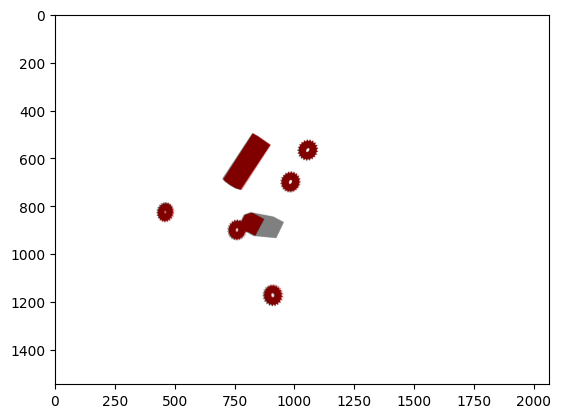

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from intrinsic_ipd.render import render_scene
import cv2

image, rendered_gt, overlay_gt = render_scene(reader, 30)
image, rendered_pred, overlay_pred = render_scene(reader, 30, poses=ordered_matcher.get_matched_poses())

# set rendered prediction to red
rendered_pred = np.array(rendered_pred)
black_pixels = np.where(
    (rendered_pred[:, :, 0] == 0) & 
    (rendered_pred[:, :, 1] == 0) & 
    (rendered_pred[:, :, 2] == 0)
)
rendered_pred[black_pixels] = [255, 0, 0]


alpha = 0.5  # Transparency of the overlay
gt_vs_est = cv2.addWeighted(rendered_gt, 1 - alpha, rendered_pred, alpha, 0)
plt.imshow(gt_vs_est)